In [2]:
#!pip install pandas matplotlib seaborn scikit-learn numpy imblearn xgboost -q

In [3]:
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [4]:
# --- 1. Setup ---
INPUT_FILE = 'atendimentos_de_alunos_processado.csv'
OUTPUT_FILE = 'atendimentos_de_alunos_machine_learning.csv'

# Columns to remove
COLUMNS_TO_DROP = [
    'Grupo_percent_Cursado', 'MATRICULAID', '1º_NOME', 'DATAMATRICULA',
    'Data_de_nascimento', 'ENCERRAMENTO_CONTRATO',
    'DATAMATRICULA_is_missing', 'ENCERRAMENTO_CONTRATO_is_missing',
    'Data_de_nascimento_is_missing', 'Situação_Contrato'
]

# Define exceptions for boolean conversion
# These columns will be treated as numeric and scaled, even if they only contain 0s and 1s.
BOOLEAN_CONVERSION_EXCEPTIONS = [
    'Correção_-_Plataforma', 'Ouvidoria', 'Processos_Secretaria', 'Suporte_Pedagogico'
]


# --- 2. Processing Pipeline ---
# Load data and clean column names in one go

df = pd.read_csv(INPUT_FILE, sep=';')

df.columns = (df.columns.str.strip().str.replace(' ', '_', regex=False).str.replace('%', 'percent', regex=False).str.replace('#', 'num', regex=False))

# Drop irrelevant columns
df.drop(columns=COLUMNS_TO_DROP, inplace=True, errors='ignore')

# Convert percentage columns to float
for col in ['PercentualConclusao', 'percent_Docs_Pessoais']:
    if col in df.columns:
        df[col] = df[col].str.replace(',', '.', regex=False).astype(float)

# Identify and convert binary (0/1) numeric columns to boolean, respecting exceptions
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
binary_cols = []
for col in numeric_cols:
    # Check if the column contains only 0s and 1s AND is NOT in the exception list
    is_binary = df[col].dropna().isin([0, 1]).all()
    if is_binary and col not in BOOLEAN_CONVERSION_EXCEPTIONS:
        binary_cols.append(col)

if binary_cols:
    df[binary_cols] = df[binary_cols].astype(bool)

# Identify remaining numeric columns for scaling (this will now include the exceptions)
cols_to_scale = [col for col in numeric_cols if col not in binary_cols]

# Scale the remaining numeric columns
scaler = StandardScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

# One-hot encode the remaining categorical columns
df_processed = pd.get_dummies(df, drop_first=True)

# Convert 'churn' column back to integer (1 and 0)
if 'churn' in df_processed.columns:
    df_processed['churn'] = df_processed['churn'].astype(int)


# --- 3. Save the Result ---
df_processed.to_csv(OUTPUT_FILE, index=False, sep=';')

In [5]:
from sklearn.model_selection import train_test_split

df = pd.read_csv(OUTPUT_FILE, sep=';')

# Define features (X) and target (y)

X = df.drop('churn', axis=1)
y = df['churn']

# First split: train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: train and validation (from X_temp)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (10886, 154)
Validation shape: (2722, 154)
Test shape: (3403, 154)


/tmp/ipykernel_13814/2592352302.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, ax=ax_importance, palette='viridis')


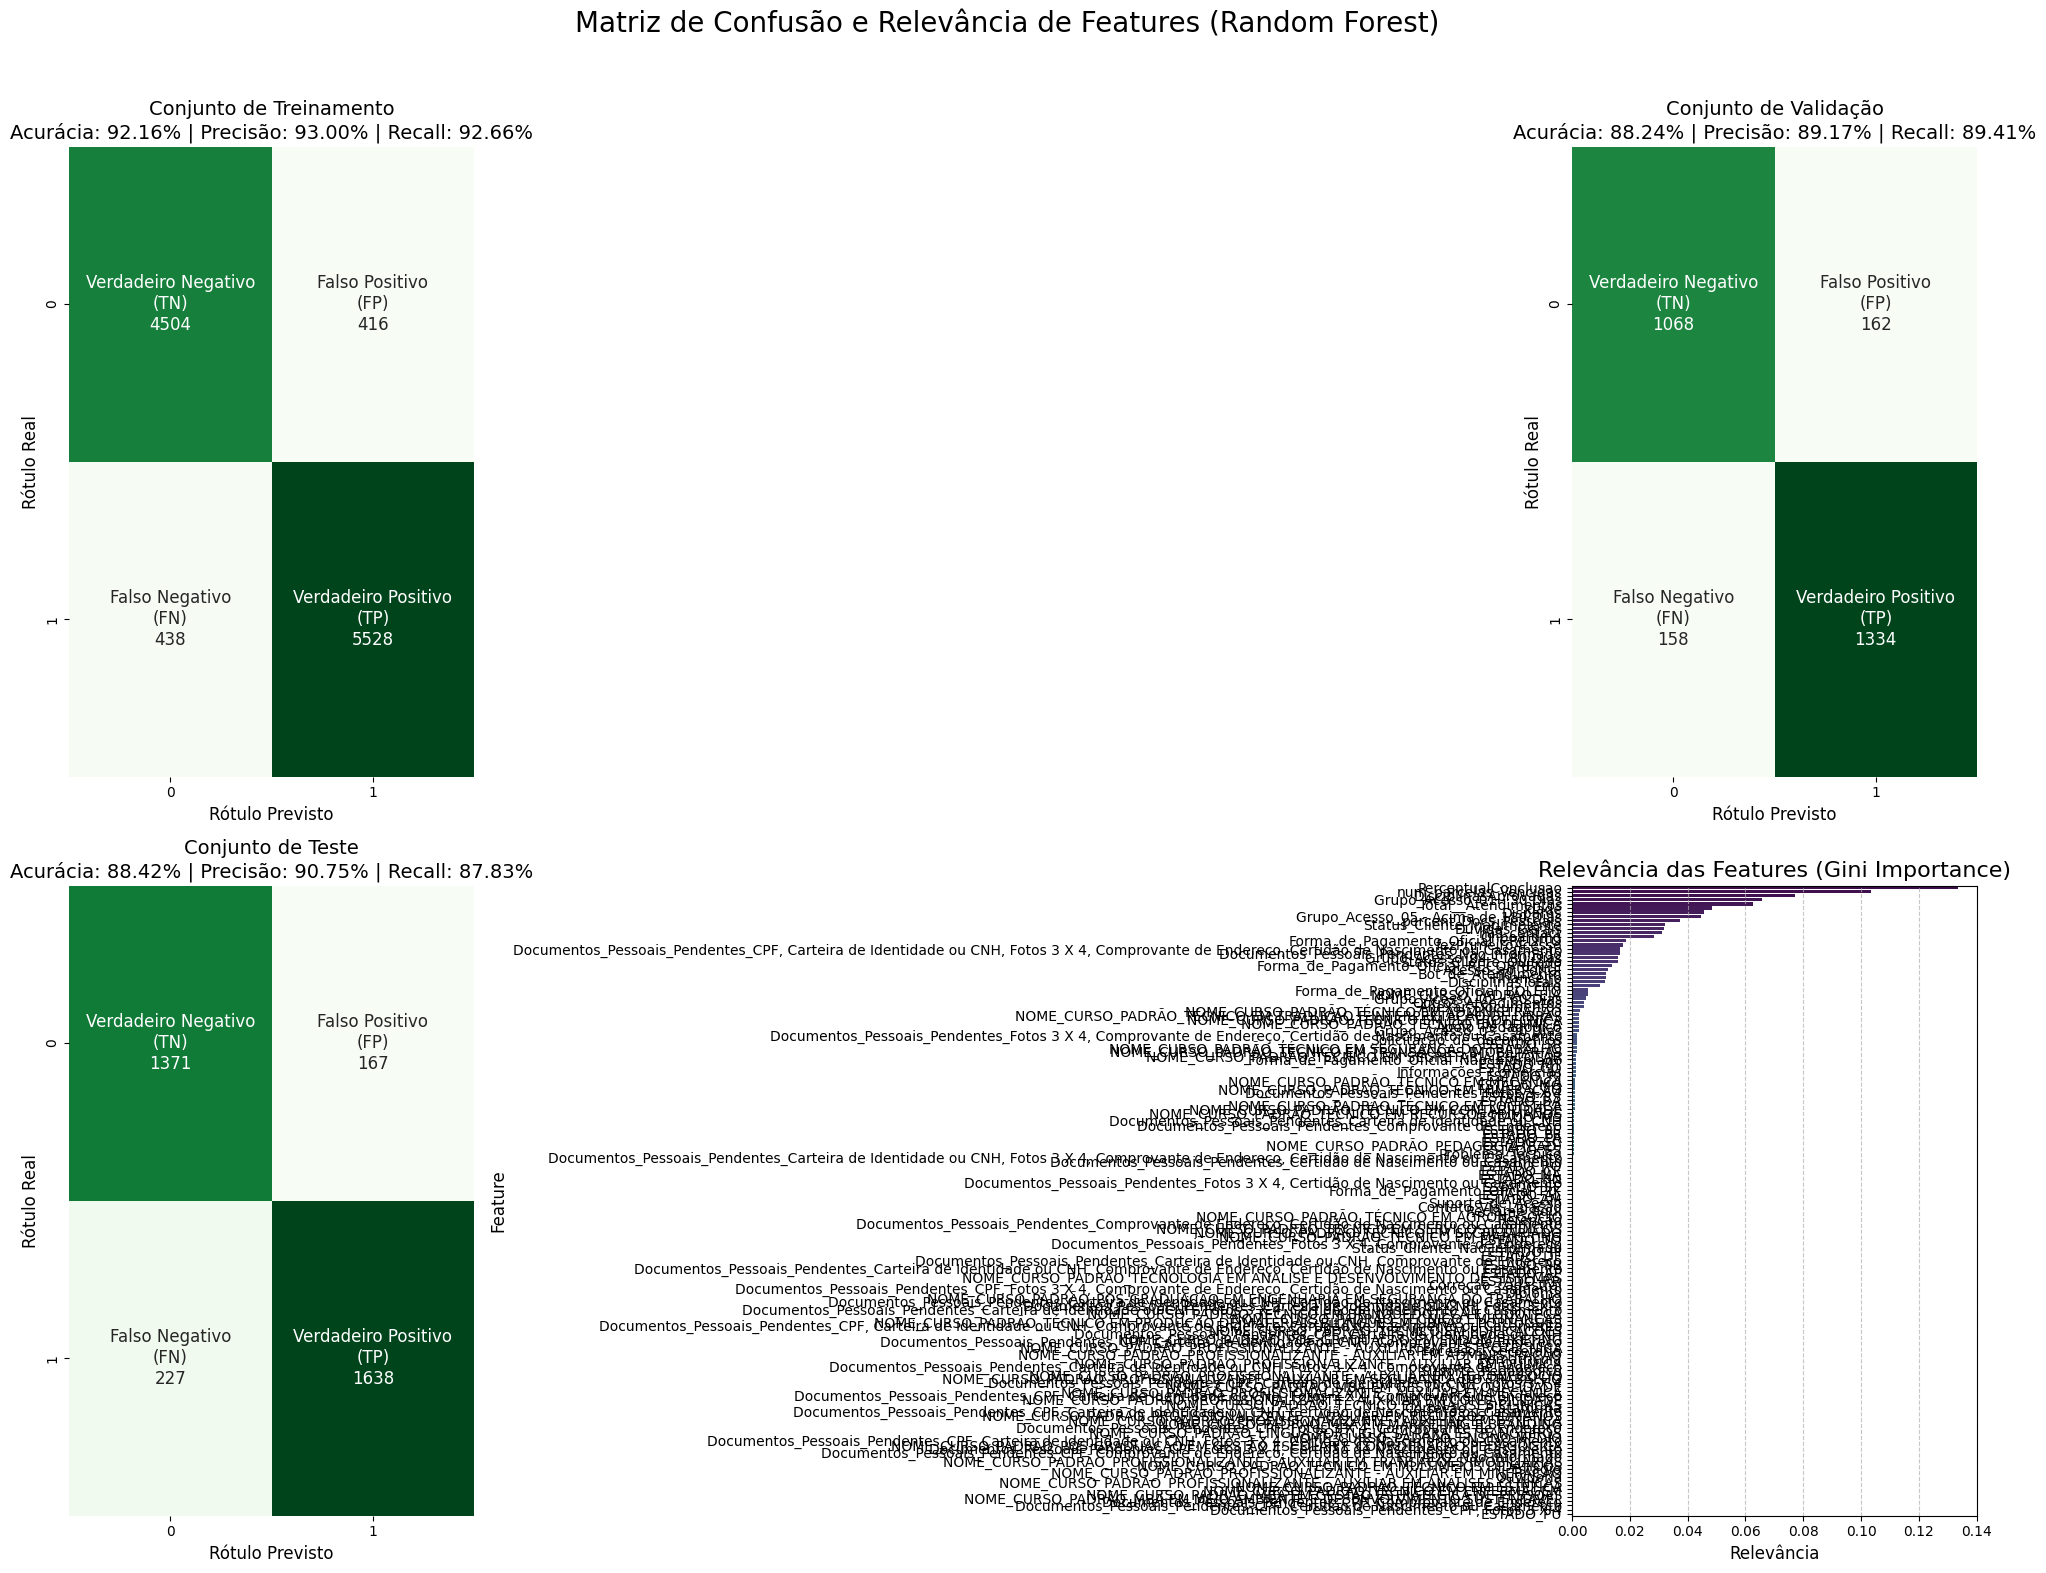

In [ ]:
# --- Bibliotecas Necessárias ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# --- PRÉ-REQUISITO (ASSUMIDO) ---
# As seguintes variáveis já devem existir no seu script:
# X_train, X_val, X_test: DataFrames do Pandas ou arrays NumPy com as features.
# y_train, y_val, y_test: Series do Pandas ou arrays NumPy com os rótulos (target).
# X_train deve ter os nomes das colunas se for um DataFrame.

# --- Dimensionamento de Features (Feature Scaling) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# --- Treinamento do Modelo (Random Forest) ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
rf_model.fit(X_train_scaled, y_train)

# --- Previsões ---
y_train_pred = rf_model.predict(X_train_scaled)
y_val_pred = rf_model.predict(X_val_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

# --- Função de Plotagem para uma Única Matriz ---
def plot_single_confusion_matrix(ax, y_true, y_pred, title):
    """
    Plota uma única matriz de confusão anotada em um determinado eixo do matplotlib.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if cm.shape != (2, 2):
        ax.text(0.5, 0.5, 'Não foi possível gerar a matriz.\nVerifique os rótulos y_true e y_pred.', 
                ha='center', va='center', fontsize=10)
        ax.set_title(title, fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
        return
        
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    labels = np.array([
        [f'Verdadeiro Negativo\n(TN)\n{tn}', f'Falso Positivo\n(FP)\n{fp}'],
        [f'Falso Negativo\n(FN)\n{fn}', f'Verdadeiro Positivo\n(TP)\n{tp}']
    ])
    sns.heatmap(cm, annot=labels, fmt='', cmap='Greens', cbar=False, ax=ax, annot_kws={"size": 12})
    subtitle = f'Acurácia: {accuracy:.2%} | Precisão: {precision:.2%} | Recall: {recall:.2%}'
    ax.set_title(f'{title}\n{subtitle}', fontsize=14)
    ax.set_ylabel('Rótulo Real', fontsize=12)
    ax.set_xlabel('Rótulo Previsto', fontsize=12)

# --- Criar a Imagem Consolidada ---
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Matriz de Confusão e Relevância de Features (Random Forest)', fontsize=20, y=0.98)
axes = axes.ravel()

# Plotar cada matriz de confusão
plot_single_confusion_matrix(axes[0], y_train, y_train_pred, 'Conjunto de Treinamento')
plot_single_confusion_matrix(axes[1], y_val, y_val_pred, 'Conjunto de Validação')
plot_single_confusion_matrix(axes[2], y_test, y_test_pred, 'Conjunto de Teste')

# --- Plotar a Relevância das Features (Feature Importance) ---
ax_importance = axes[3]
importances = rf_model.feature_importances_
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'Feature {i}' for i in range(X_train.shape[1])]
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# --- MODIFICAÇÃO AQUI ---
# Criar o gráfico de barras com as 10 features mais importantes
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance_df.head(10), # Seleciona apenas as 10 primeiras linhas
    ax=ax_importance, 
    palette='viridis'
)

# Ajustar o título para refletir a mudança
ax_importance.set_title('Top 10 Features Mais Relevantes (Gini Importance)', fontsize=16)
ax_importance.set_xlabel('Relevância', fontsize=12)
ax_importance.set_ylabel('Feature', fontsize=12)
ax_importance.grid(axis='x', linestyle='--', alpha=0.7)

# Ajustar o layout e exibir o gráfico
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('random_forest_analysis.png')
plt.show()

NameError: name 'X_full' is not defined

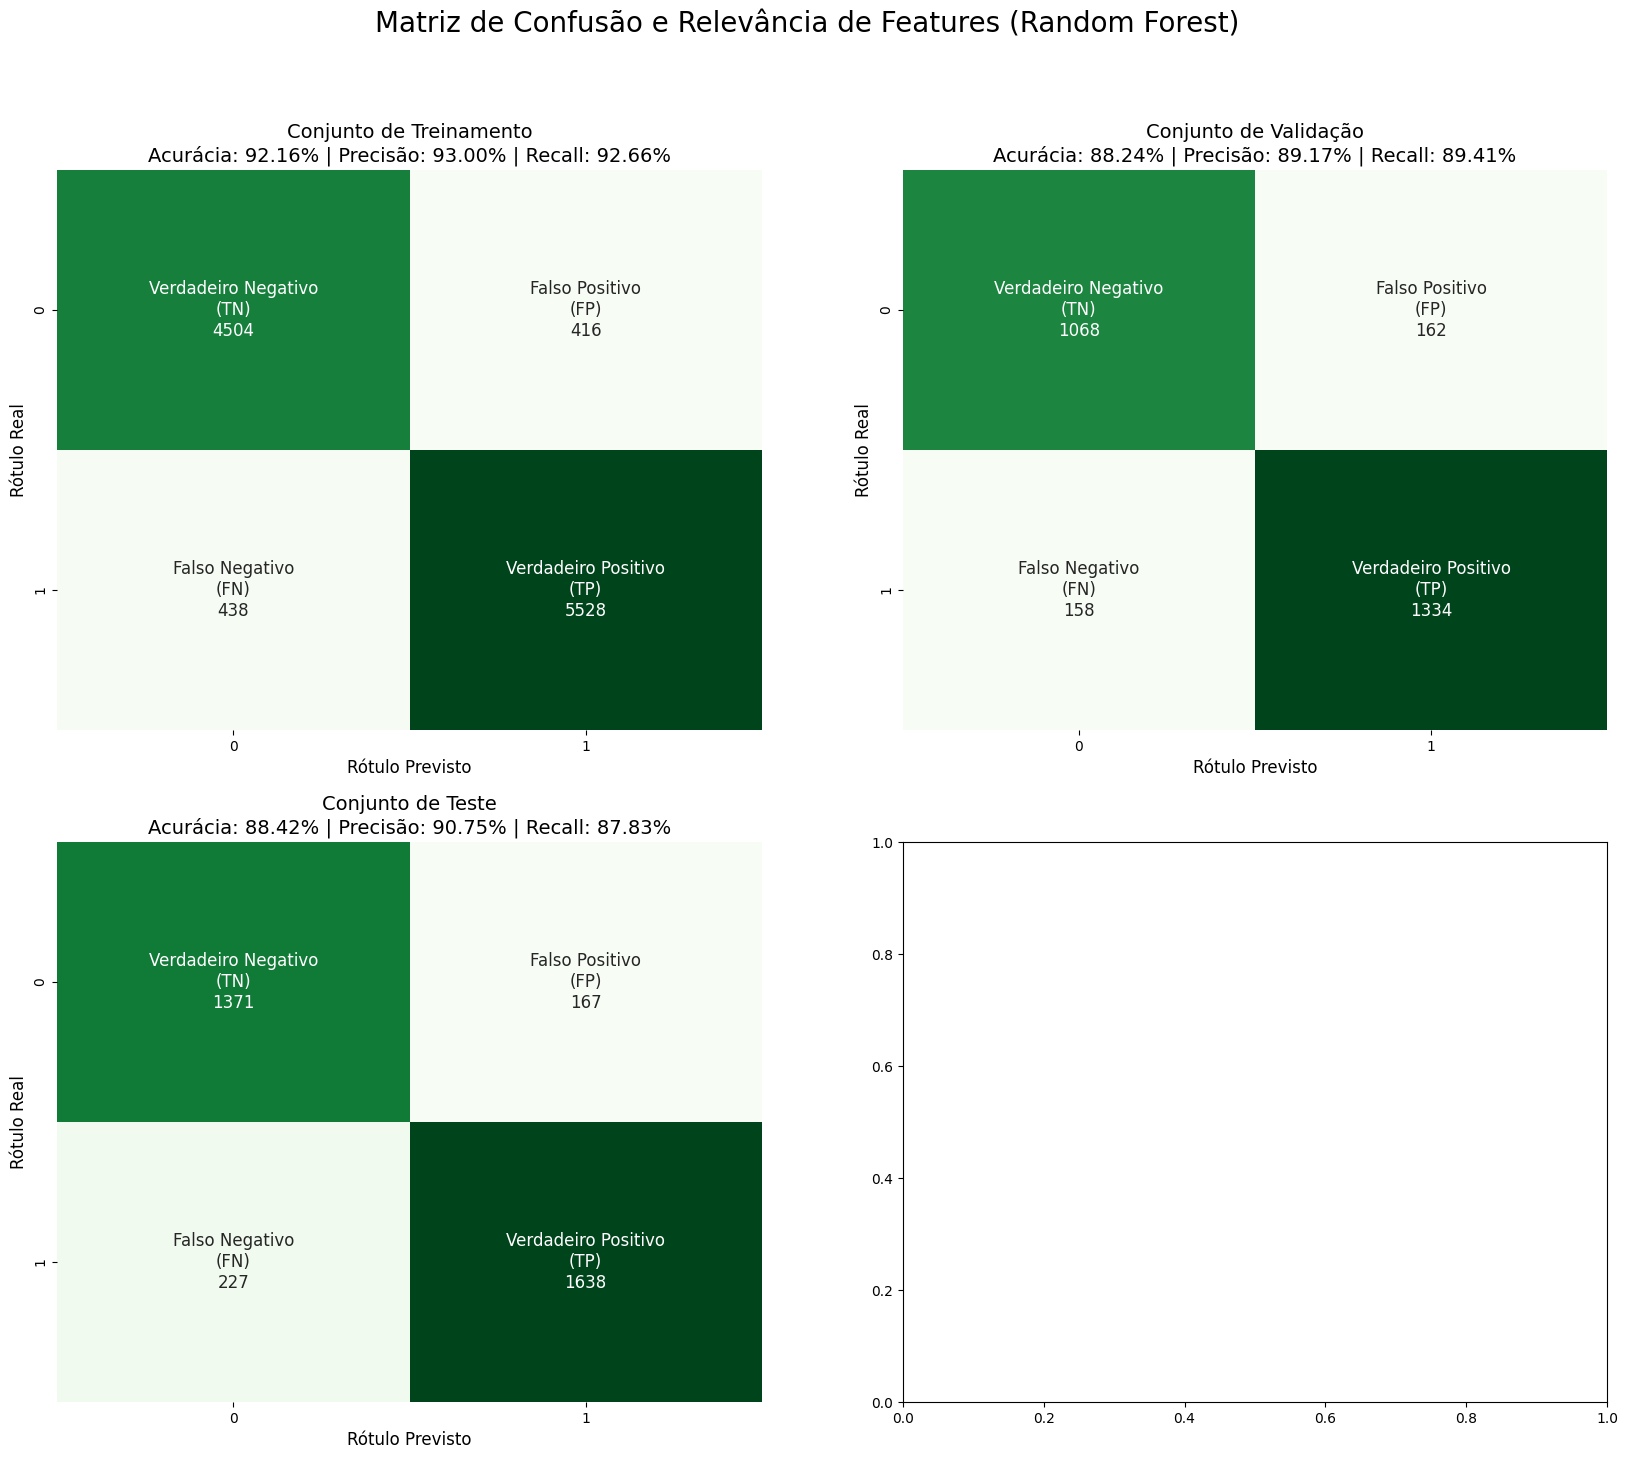

In [7]:
# --- Dimensionamento de Features (Feature Scaling) ---
# É uma boa prática, embora Random Forest não seja tão sensível à escala.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# --- Treinamento do Modelo (Random Forest) ---
# Instanciamos o RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
rf_model.fit(X_train_scaled, y_train)

# --- Previsões ---
y_train_pred = rf_model.predict(X_train_scaled)
y_val_pred = rf_model.predict(X_val_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

# --- Função de Plotagem para uma Única Matriz (sem modificações) ---
def plot_single_confusion_matrix(ax, y_true, y_pred, title):
    """
    Plota uma única matriz de confusão anotada em um determinado eixo do matplotlib.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    # Previne divisão por zero
    if cm.shape != (2, 2):
        # Adiciona um texto indicando que a matriz não pôde ser gerada
        ax.text(0.5, 0.5, 'Não foi possível gerar a matriz.\nVerifique os rótulos y_true e y_pred.', 
                ha='center', va='center', fontsize=10)
        ax.set_title(title, fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
        return
        
    tn, fp, fn, tp = cm.ravel()

    # Calcular métricas
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Criar os textos dos rótulos para cada célula
    labels = np.array([
        [f'Verdadeiro Negativo\n(TN)\n{tn}', f'Falso Positivo\n(FP)\n{fp}'],
        [f'Falso Negativo\n(FN)\n{fn}', f'Verdadeiro Positivo\n(TP)\n{tp}']
    ])

    # Plotar o mapa de calor (heatmap)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Greens', cbar=False, ax=ax, annot_kws={"size": 12})
    
    # Definir títulos e rótulos
    subtitle = f'Acurácia: {accuracy:.2%} | Precisão: {precision:.2%} | Recall: {recall:.2%}'
    ax.set_title(f'{title}\n{subtitle}', fontsize=14)
    ax.set_ylabel('Rótulo Real', fontsize=12)
    ax.set_xlabel('Rótulo Previsto', fontsize=12)

# --- Criar a Imagem Consolidada ---
fig, axes = plt.subplots(2, 2, figsize=(20, 16)) # Ajuste no tamanho para melhor visualização
fig.suptitle('Matriz de Confusão e Relevância de Features (Random Forest)', fontsize=20, y=0.98)

# Achata o array de eixos para facilitar a iteração
axes = axes.ravel()

# Plotar cada matriz de confusão
plot_single_confusion_matrix(axes[0], y_train, y_train_pred, 'Conjunto de Treinamento')
plot_single_confusion_matrix(axes[1], y_val, y_val_pred, 'Conjunto de Validação')
plot_single_confusion_matrix(axes[2], y_test, y_test_pred, 'Conjunto de Teste')

# --- Plotar a Relevância das Features (Feature Importance) ---
ax_importance = axes[3]

# Obter a importância das features do modelo treinado
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_full.columns, # Usar os nomes das colunas originais
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Criar o gráfico de barras
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, ax=ax_importance, palette='viridis')

# Configurar títulos e rótulos do gráfico de importância
ax_importance.set_title('Relevância das Features (Gini Importance)', fontsize=16)
ax_importance.set_xlabel('Relevância', fontsize=12)
ax_importance.set_ylabel('Feature', fontsize=12)
ax_importance.grid(axis='x', linestyle='--', alpha=0.7)

# Ajustar o layout e exibir o gráfico
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()